<a href="https://colab.research.google.com/github/diegootero11/TFG-CODIGO-Y-BASES-DE-DATOS-DIEGO-OTERO/blob/main/M%26A_ANALISIS_DEL_DATO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df_MAs=pd.read_excel("/content/df_MAs_no_null.xlsx")

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 5))
sns.histplot(df_MAs['Deal_Value_USD_Millions'], bins=50, kde=True)
plt.title('Distribución de Deal_Value_USD_Millions antes de eliminar outliers')
plt.xlabel('Deal_Value_USD_Millions')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:

print(f"Número de observaciones: {df_MAs.shape[0]}")
print(f"Número de variables: {df_MAs.shape[1]}")


print("\nColumnas del DataFrame:")
for col in df_MAs.columns:
    print(f"- {col}")


Número de observaciones: 3613
Número de variables: 23

Columnas del DataFrame:
- Target_Macro_Industry
- Target_Nation
- Acquiror_Macro_Industry
- Acquiror_Nation
- MA_TRBC_Activi
- Deal_Value_USD_Millions
- Consideration_Structure
- SDC_Deal_Type
- Deal_Attitude
- Form_of_the_Deal
- Percentage_of_Shares_Acquiror_is_Seeking_to_Own_after_Transaction
- EBITDA_Margin
- Accounts_Receivable_Last_12_Months_USD_Millions
- Accounts_Payable_Last_12_Months_USD_Millions
- Common_Equity_Last_12_Months_USD_Millions
- Total_Assets_Last_12_Months_USD_Millions
- Short_Term_Debt_Last_12_Months_USD_Millions
- Long_Term_Debt_Last_12_Months_USD_Millions
- Target_Net_Income_Last_12_Months_USD_Millions
- GDP_Announced_Target
- CPI_Announced_Target
- Interest_Rate_Announced_Target
- M2_Announced_Target


In [ ]:

y = df_MAs['Deal_Value_USD_Millions']
X = df_MAs.drop(columns=['Deal_Value_USD_Millions'])


In [ ]:
from sklearn.preprocessing import LabelEncoder


categorical_columns = X.select_dtypes(include='object').columns


X[categorical_columns] = X[categorical_columns].astype(str)


label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


RV SEARCH DE LOS 3 MODELOS (RF, GB, XGB)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

from sklearn.model_selection import RandomizedSearchCV


models = {
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 0.8]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 1.0]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(random_state=42, objective='reg:squarederror'),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0, 0.5, 1],
            'reg_lambda': [1, 2, 3]
        }
    }
}


results = {}

for name, config in models.items():
    print(f"\nEntrenando {name} con RandomizedSearchCV...")
    search = RandomizedSearchCV(
        estimator=config['model'],
        param_distributions=config['params'],
        n_iter=20,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    results[name] = {
        'Mejores parámetros': search.best_params_,
        'MAE Train': mean_absolute_error(y_train, y_train_pred),
        'MAE Test': mean_absolute_error(y_test, y_test_pred),
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2 Train': r2_score(y_train, y_train_pred),
        'R2 Test': r2_score(y_test, y_test_pred)
    }

    print(f"\nMejores parámetros de {name}: {search.best_params_}")
    print(f"Métricas de {name}:")
    for metric, value in results[name].items():
        if metric != 'Mejores parámetros':
            print(f"{metric}: {value:.4f}")


results_df = pd.DataFrame(results).T
print("\nResumen final:")
print(results_df)



Entrenando Random Forest con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros de Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.8, 'max_depth': 15}
Métricas de Random Forest:
MAE Train: 31.1156
MAE Test: 50.6083
RMSE Train: 56.6554
RMSE Test: 85.8819
R2 Train: 0.8311
R2 Test: 0.6044

Entrenando Gradient Boosting con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros de Gradient Boosting: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.05}
Métricas de Gradient Boosting:
MAE Train: 24.0648
MAE Test: 47.1539
RMSE Train: 39.4089
RMSE Test: 81.9351
R2 Train: 0.9183
R2 Test: 0.6399

Entrenando XGBoost con RandomizedSearchCV...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Mejores parámetros de XGBoost: {'subsample': 0.8, 'reg_lambda': 3, 'reg_a

MODELOS AJUSTADOS MANUALMENTE (HIPERPARAMETROS)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd


models_finetuned = {
    'Random Forest': Pipeline([
        ('scaler', RobustScaler()),
        ('model', RandomForestRegressor(
            n_estimators=150,
            max_depth=5,
            min_samples_split=12,
            min_samples_leaf=10,
            max_features=0.8,
            bootstrap=True,
            random_state=42
        ))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.03,
            max_depth=3,
            min_samples_split=12,
            min_samples_leaf=6,
            subsample=0.85,
            max_features=0.85,
            random_state=42
        ))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('model', XGBRegressor(
            n_estimators=200,
            learning_rate=0.03,
            max_depth=3,
            min_child_weight=6,
            gamma=1,
            subsample=0.85,
            colsample_bytree=0.85,
            reg_alpha=3,
            reg_lambda=4,
            random_state=42,
            objective='reg:squarederror'
        ))
    ])
}


results = {}
modelos_entrenados = {}

for name, pipeline in models_finetuned.items():
    print(f"\nEntrenando {name}...")
    pipeline.fit(X_train, y_train)
    modelos_entrenados[name] = pipeline

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    results[name] = {
        'MAE Train': mean_absolute_error(y_train, y_train_pred),
        'MAE Test': mean_absolute_error(y_test, y_test_pred),
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE Test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2 Train': r2_score(y_train, y_train_pred),
        'R2 Test': r2_score(y_test, y_test_pred)
    }

    print(f"\nMétricas de {name}:")
    for metric, value in results[name].items():
        print(f"{metric}: {value:.4f}")


results_df = pd.DataFrame(results).T
print("\nResumen final:")
print(results_df)



Entrenando Random Forest...

Métricas de Random Forest:
MAE Train: 51.4702
MAE Test: 57.2728
RMSE Train: 87.3602
RMSE Test: 93.9359
R2 Train: 0.5985
R2 Test: 0.5267

Entrenando Gradient Boosting...

Métricas de Gradient Boosting:
MAE Train: 46.6239
MAE Test: 52.6358
RMSE Train: 77.9968
RMSE Test: 86.2323
R2 Train: 0.6799
R2 Test: 0.6012

Entrenando XGBoost...

Métricas de XGBoost:
MAE Train: 49.5396
MAE Test: 53.3834
RMSE Train: 84.0091
RMSE Test: 86.9708
R2 Train: 0.6287
R2 Test: 0.5943

Resumen final:
                   MAE Train   MAE Test  RMSE Train  RMSE Test  R2 Train  \
Random Forest      51.470228  57.272830   87.360244  93.935858  0.598473   
Gradient Boosting  46.623893  52.635774   77.996849  86.232336  0.679933   
XGBoost            49.539649  53.383393   84.009110  86.970767  0.628687   

                    R2 Test  
Random Forest      0.526729  
Gradient Boosting  0.601170  
XGBoost            0.594310  


In [ ]:
import pandas as pd


feature_names = X_train.columns


for name, pipeline in modelos_entrenados.items():
    model = pipeline.named_steps['model']

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        df_importancia = pd.DataFrame({
            'Variable': feature_names,
            'Importancia': importances
        }).sort_values(by='Importancia', ascending=False).head(15)

        print(f"\n=== Importancia de variables: {name} ===")
        display(df_importancia)
    else:
        print(f"{name} no proporciona importancias.")



=== Importancia de variables: Random Forest ===


,Variable,Importancia
14,Total_Assets_Last_12_Months_USD_Millions,0.301206
8,Form_of_the_Deal,0.208233
13,Common_Equity_Last_12_Months_USD_Millions,0.128002
17,Target_Net_Income_Last_12_Months_USD_Millions,0.100649
1,Target_Nation,0.070076
9,Percentage_of_Shares_Acquiror_is_Seeking_to_Ow...,0.062055
10,EBITDA_Margin,0.017445
6,SDC_Deal_Type,0.016889
11,Accounts_Receivable_Last_12_Months_USD_Millions,0.015768
20,Interest_Rate_Announced_Target,0.015168



=== Importancia de variables: Gradient Boosting ===


,Variable,Importancia
14,Total_Assets_Last_12_Months_USD_Millions,0.261043
8,Form_of_the_Deal,0.151558
17,Target_Net_Income_Last_12_Months_USD_Millions,0.123451
13,Common_Equity_Last_12_Months_USD_Millions,0.120397
1,Target_Nation,0.100705
9,Percentage_of_Shares_Acquiror_is_Seeking_to_Ow...,0.078034
12,Accounts_Payable_Last_12_Months_USD_Millions,0.026678
10,EBITDA_Margin,0.021524
11,Accounts_Receivable_Last_12_Months_USD_Millions,0.020048
20,Interest_Rate_Announced_Target,0.017732



=== Importancia de variables: XGBoost ===


,Variable,Importancia
6,SDC_Deal_Type,0.202047
8,Form_of_the_Deal,0.111651
1,Target_Nation,0.096415
14,Total_Assets_Last_12_Months_USD_Millions,0.094039
13,Common_Equity_Last_12_Months_USD_Millions,0.067806
9,Percentage_of_Shares_Acquiror_is_Seeking_to_Ow...,0.066256
17,Target_Net_Income_Last_12_Months_USD_Millions,0.056583
11,Accounts_Receivable_Last_12_Months_USD_Millions,0.035224
10,EBITDA_Margin,0.034468
12,Accounts_Payable_Last_12_Months_USD_Millions,0.031014



Generando curva de aprendizaje para Random Forest...


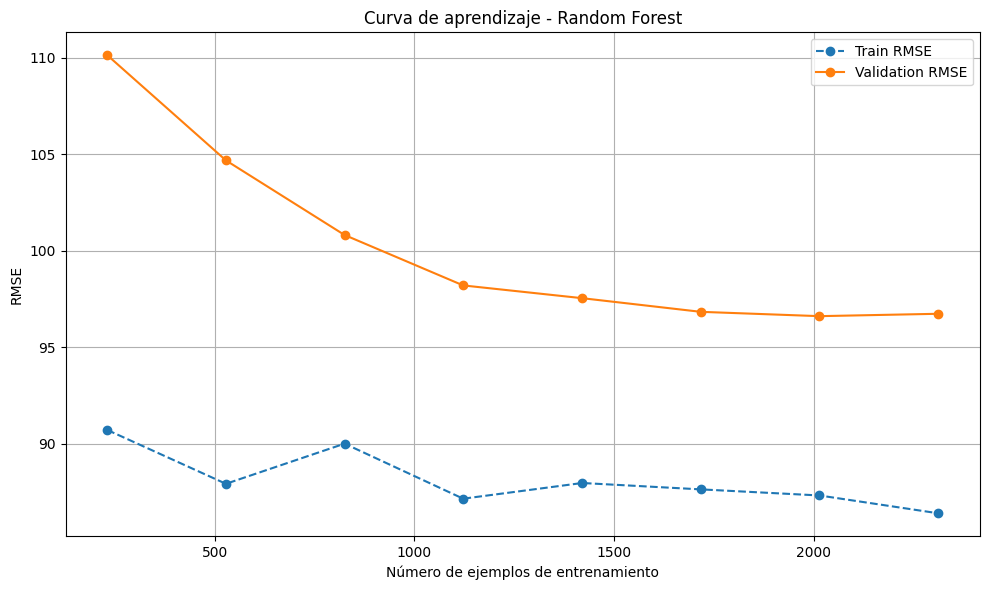


Generando curva de aprendizaje para Gradient Boosting...


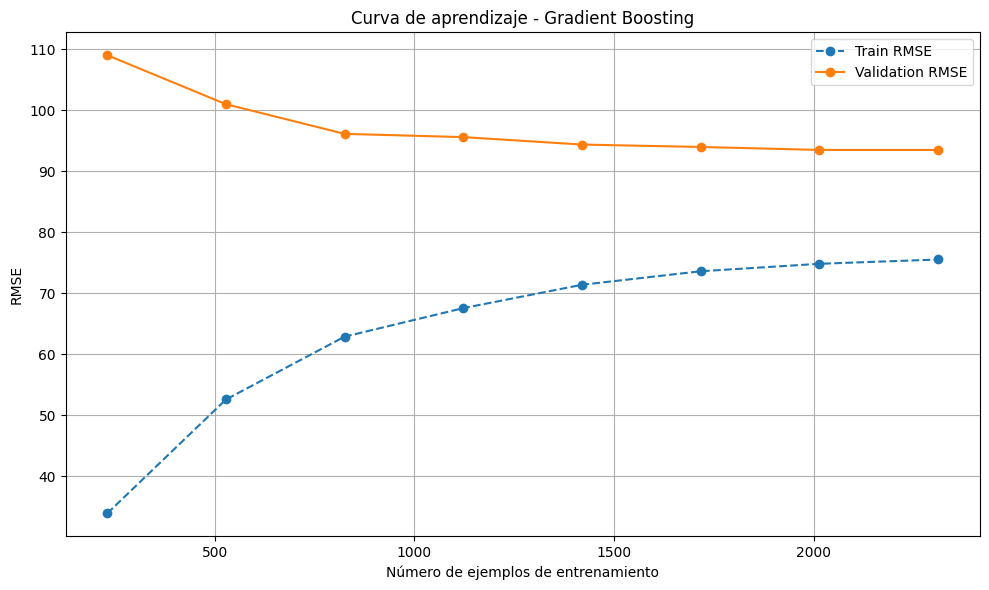


Generando curva de aprendizaje para XGBoost...


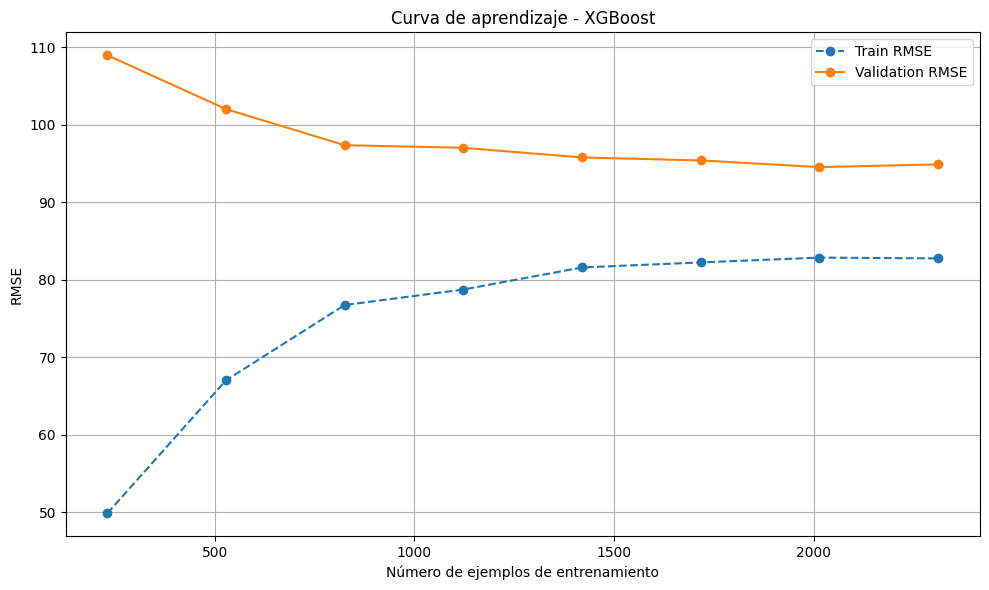

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np


model_names = list(modelos_entrenados.keys())
train_sizes = np.linspace(0.1, 1.0, 8)
cv = 5


for name in model_names:
    model = modelos_entrenados[name]
    print(f"\nGenerando curva de aprendizaje para {name}...")

    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        train_sizes=train_sizes,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)


    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes_abs, train_rmse, label='Train RMSE', linestyle='--', marker='o')
    plt.plot(train_sizes_abs, val_rmse, label='Validation RMSE', marker='o')
    plt.title(f'Curva de aprendizaje - {name}')
    plt.xlabel('Número de ejemplos de entrenamiento')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


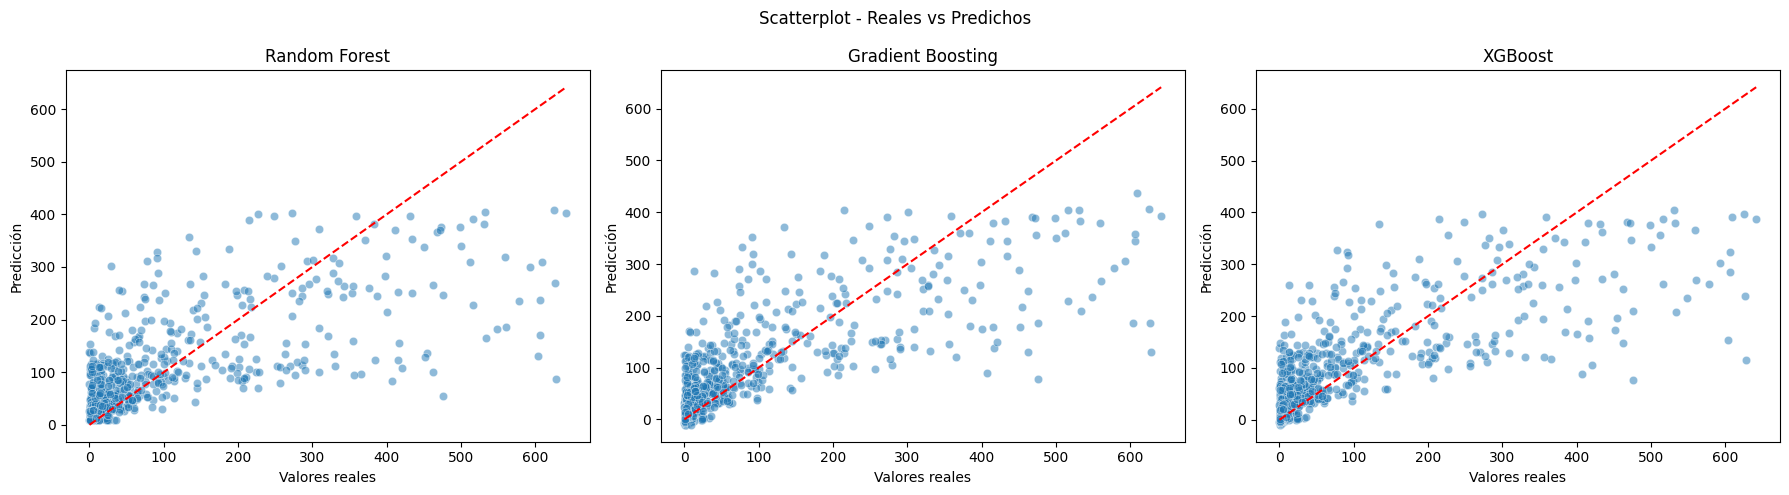

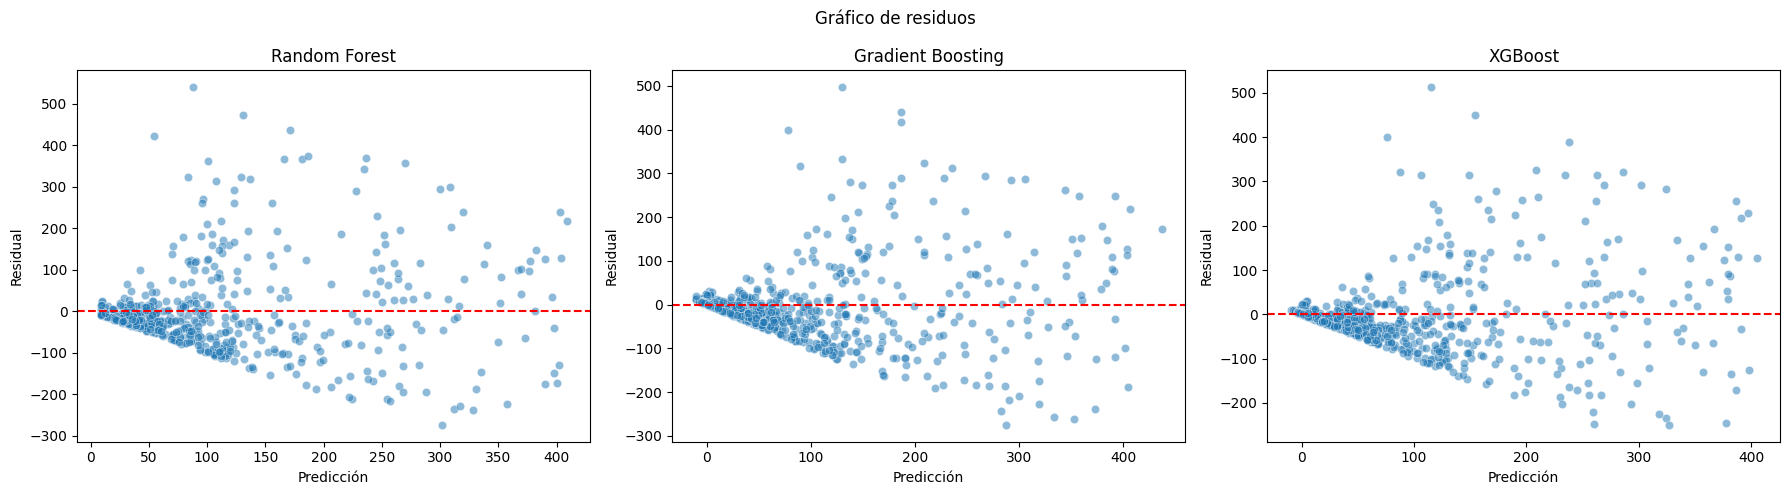

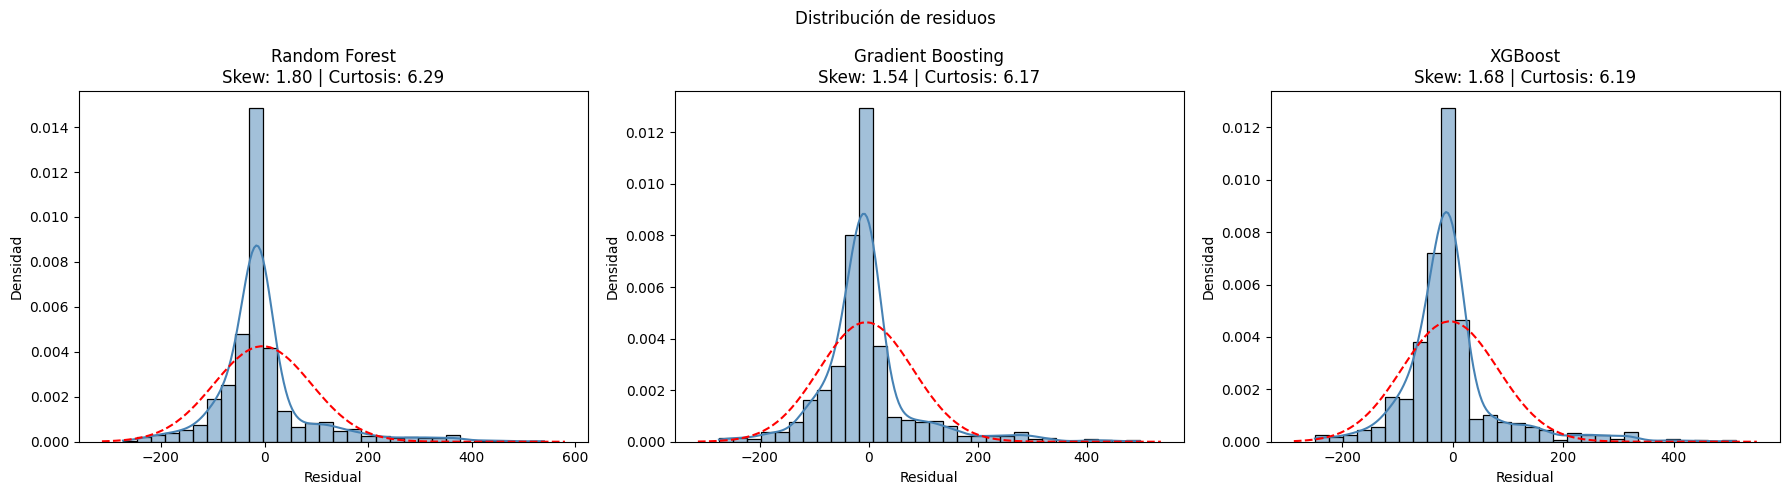

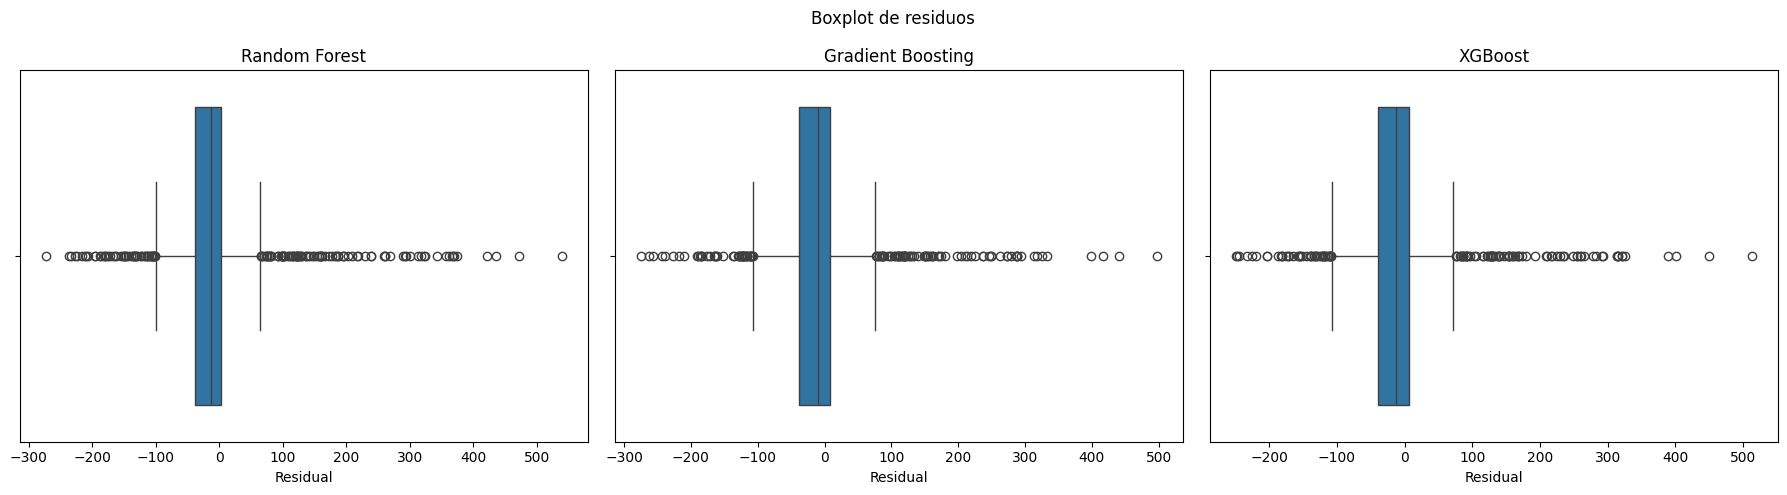

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis


residuos_dict = {}

for name, pipeline in modelos_entrenados.items():
    y_pred = pipeline.predict(X_test)
    residuos = y_test - y_pred
    residuos_dict[name] = {'pred': y_pred, 'residuos': residuos}


plt.figure(figsize=(18, 5))
for i, (name, values) in enumerate(residuos_dict.items()):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=y_test, y=values['pred'], alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name}')
    plt.xlabel('Valores reales')
    plt.ylabel('Predicción')
plt.suptitle('Scatterplot - Reales vs Predichos')
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 5))
for i, (name, values) in enumerate(residuos_dict.items()):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=values['pred'], y=values['residuos'], alpha=0.5)
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f'{name}')
    plt.xlabel('Predicción')
    plt.ylabel('Residual')
plt.suptitle('Gráfico de residuos')
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 5))
for i, (name, values) in enumerate(residuos_dict.items()):
    plt.subplot(1, 3, i+1)
    sns.histplot(values['residuos'], bins=30, kde=True, stat="density", color='steelblue')
    mu, std = norm.fit(values['residuos'])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', label='Normal')
    skew_val = skew(values['residuos'])
    kurt = kurtosis(values['residuos'])
    plt.title(f"{name}\nSkew: {skew_val:.2f} | Curtosis: {kurt:.2f}")
    plt.xlabel("Residual")
    plt.ylabel("Densidad")
plt.suptitle('Distribución de residuos')
plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 5))
for i, (name, values) in enumerate(residuos_dict.items()):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=values['residuos'], orient='h')
    plt.title(name)
    plt.xlabel("Residual")
plt.suptitle("Boxplot de residuos")
plt.tight_layout()
plt.show()
